[nltk_data] Downloading package punkt to
[nltk_data]     /Users/robinwoodfamily/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robinwoodfamily/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/6_/x10j3qv524qdjmnwk9l24_940000gn/T/ipykernel_6781/344719161.py:182: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


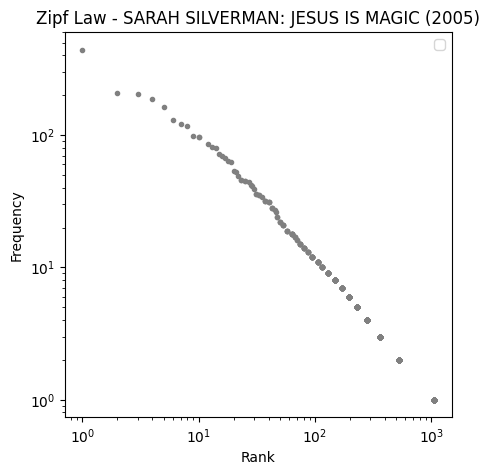

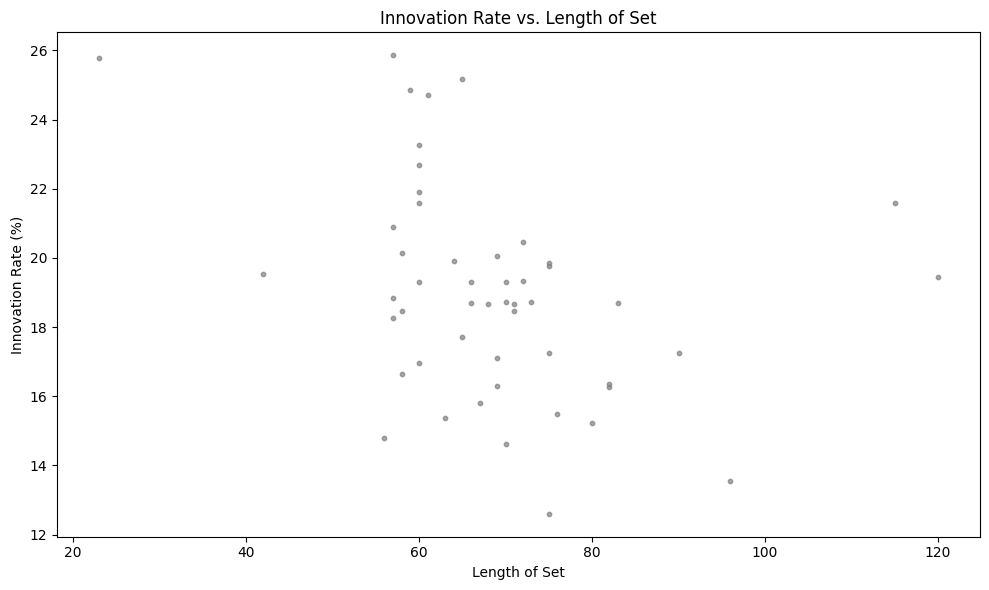

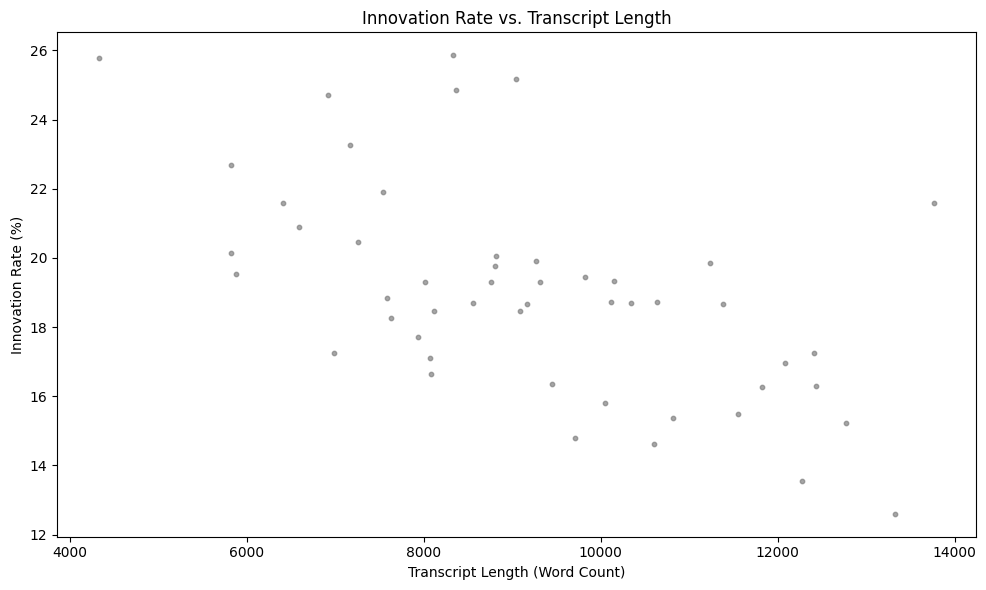

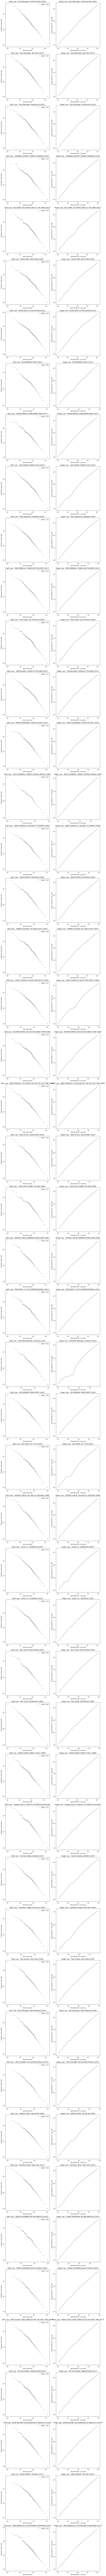

<Figure size 640x480 with 0 Axes>

In [228]:
import re
import pandas as pd
import requests
import json
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer,TweetTokenizer
from nltk.corpus import stopwords
from nltk import download
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

download('punkt')
download('stopwords')

url = 'https://raw.githubusercontent.com/marobinette/pocs/main/project/comedy_data_10_31.csv'

df = pd.read_csv(url)
df = df[['title', 'length', 'transcript']]

def trimTitle(title):
    trimmedTitle = title.split('–')[0]
    # remove whitespace at the end
    trimmedTitle = trimmedTitle.rstrip()
    return trimmedTitle

# apply trimTitle to the title column
df['title'] = df['title'].apply(trimTitle)  

def export_comedian_word_data(word_data, comedian):
    """
    Exports the word data for a specific comedian to a CSV file.
    
    Parameters:
    - word_data (DataFrame): DataFrame containing words, counts, total unique words, and probabilities.
    - comedian (str): Name of the comedian to label the CSV file.
    """
    word_data = word_data.rename(columns={'word': 'types'})
    word_data = word_data[['types', 'counts', 'total_unique', 'probs']]    
    filename = f"{comedian}.csv"
    word_data.to_csv(filename, index=False)
    print(f"Data exported to {filename} successfully.")

def get_word_data(words):
    """
    Generates word frequency data including counts and probabilities.
    
    Parameters:
    - words (list): List of words to analyze for frequency and probability.
    
    Returns:
    - DataFrame: DataFrame with word counts, probabilities, and total unique word count.
    """
    word_data = pd.Series(words).value_counts().reset_index()
    word_data.columns = ['word', 'counts']        
    word_data['probs'] = word_data['counts'] / word_data['counts'].sum()    
    word_data['total_unique'] = len(word_data)
    word_data = word_data.sort_values(by='counts', ascending=False).reset_index(drop=True)
    
    return word_data

def tokenize_words(text, remove_stop_words=False):
    """
    Tokenizes the text into words, with an option to remove stopwords.

    Parameters:
    - text (str or list): Text or list of strings to tokenize.
    - remove_stop_words (bool): Whether to remove stopwords from the tokens.

    Returns:
    - list: List of tokenized words.
    """
    if isinstance(text, list):
        text = ' '.join(text)

    # Tokenize text while preserving contractions.
    words = word_tokenize(text)

    # Remove all words in brackets or punctuation.
    tokenizer = TweetTokenizer()
    words = tokenizer.tokenize(text)
    words = [re.sub(r"[^\w\s]", '', word) for word in words]

    # Filter out empty strings resulting from punctuation removal.
    words = [word for word in words if word]

    # Remove one-letter words except "I", "a", or "A"
    words = [word for word in words if len(word) > 1 or word in ['I', 'a', 'A']]

    # remove instances of "nI"
    words = [word for word in words if word != 'nI']
    # Remove stopwords if the option is selected.
    if remove_stop_words:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word.lower() not in stop_words]

    return words


def calculate_innovation_rate(words):
    """
    Calculates the innovation rate as the ratio of unique words to the total words.
    
    Parameters:
    - words (list): List of tokenized words.
    
    Returns:
    - float: Innovation rate.
    """
    unique_words = set(words)
    # print(f"Unique words: {len(unique_words)}")
    total_words = len(words)
    # print(f"Total words: {total_words}")
    innovation_rate = len(unique_words) / total_words if total_words > 0 else 0
    return innovation_rate

def get_innovation_rate_data(df):
    """
    Returns a DataFrame with title, innovation rate, and length of set for each comedian.
    """
    titles = []
    lengths = []  # Renamed to avoid overwriting
    innovation_rates = []

    for idx, row in df.iterrows():
        title = row['title']
        length = row['length']  # Length of the set
        transcript = row['transcript']
        
        words = tokenize_words(transcript, remove_stop_words=False)
        innovation_rate = calculate_innovation_rate(words) * 100  # Convert to percentage
        
        # Append data to lists
        titles.append(title)
        lengths.append(length)
        innovation_rates.append(innovation_rate)
    
    # Create a new DataFrame with title, length, and innovation_rate columns
    innovation_rate_df = pd.DataFrame({
        'title': titles,
        'length': lengths,  # Corrected list name here
        'innovation_rate': innovation_rates
    })

    return innovation_rate_df


def plot_zipf_distribution(df, title):
    """
    Plots the Zipf distribution for the given comedian's transcript.
    
    Parameters:
    - df (DataFrame): DataFrame containing comedy data with titles and transcripts.
    - title (str): The comedian's name for which to plot the distribution.
    """
    # Filter the dataframe for the given comedian
    transcript = df[df['title'] == title]['transcript'].values[0]
    
    # Tokenize the words
    words = tokenize_words(transcript, remove_stop_words=False)
    
    # Generate word frequency data
    word_data = get_word_data(words)
    
    # Rank the words by frequency
    word_data['rank'] = word_data['counts'].rank(ascending=False, method='average').astype(int)
    
    # Log-transform rank and frequency
    log_rank = np.log10(word_data['rank'])
    log_freq = np.log10(word_data['counts'])
    
    # Perform linear regression to calculate the slope
    slope, intercept, r_value, p_value, std_err = linregress(log_rank, log_freq)
    
    # Plot the Zipf distribution (log-log scale)
    plt.figure(figsize=(5, 5))
    plt.loglog(word_data['rank'], word_data['counts'], marker=".", linestyle='none', color="grey")
    
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.title(f'Zipf Law - {title}')
    plt.legend()
    plt.savefig(f"{title}_zipf_log_space.png")
    plt.show()

def plot_innovation_rate(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['length'], df['innovation_rate'], s=10, color='grey', alpha=0.7)
    plt.xlabel('Length of Set')
    plt.ylabel('Innovation Rate (%)')
    plt.title('Innovation Rate vs. Length of Set')
    plt.tight_layout()
    plt.savefig('Innovation_Rate_Length_Set.png')
    plt.show()

def get_innovation_rate_data_with_word_count(df):
    """
    Returns a DataFrame with title, innovation rate, and word count of each comedian's set.
    """
    titles = []
    word_counts = []
    innovation_rates = []

    for idx, row in df.iterrows():
        title = row['title']
        transcript = row['transcript']
        
        words = tokenize_words(transcript, remove_stop_words=False)
        word_count = len(words)
        innovation_rate = calculate_innovation_rate(words) * 100  # Convert to percentage
        
        # Append data to lists
        titles.append(title)
        word_counts.append(word_count)
        innovation_rates.append(innovation_rate)
    
    # Create a new DataFrame with title, word_count, and innovation_rate columns
    innovation_rate_df = pd.DataFrame({
        'title': titles,
        'word_count': word_counts,
        'innovation_rate': innovation_rates
    })

    return innovation_rate_df

def plot_innovation_rate_by_word_count(df):
    """
    Plots innovation rate against the number of words in each transcript.
    
    Parameters:
    - df (DataFrame): DataFrame containing title, word_count, and innovation_rate.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(df['word_count'], df['innovation_rate'],  s=10, color='grey', alpha=0.7)
    plt.xlabel('Transcript Length (Word Count)')
    plt.ylabel('Innovation Rate (%)')
    plt.title('Innovation Rate vs. Transcript Length')
    plt.tight_layout()
    plt.savefig('Innovation_Rate_Length_Corpus.png')
    plt.show()

def calculate_vocabulary_growth(words):
    """
    Calculates vocabulary size as a function of word count for a given transcript.
    Returns a list of tuples where each tuple contains the count of words and unique words.
    """
    vocab_growth = []
    unique_words = set()
    for i, word in enumerate(words, 1):
        unique_words.add(word)
        vocab_growth.append((i, len(unique_words)))
    return np.array(vocab_growth)

def plot_heaps_law(df, title):
    """Plots Heaps' Law based on vocabulary growth for a single comedy set."""
    transcript = df[df['title'] == title]['transcript'].values[0]
    words = tokenize_words(transcript, remove_stop_words=False)
    vocab_growth = calculate_vocabulary_growth(words)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(vocab_growth[:, 0], vocab_growth[:, 1], color='grey')
    plt.xlabel("Total Words (N)")
    plt.ylabel("Unique Words")
    plt.title(f"Heaps' Law - '{title}'")
    plt.legend()
    plt.show()


# Generate the updated DataFrame and plot


import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

def plot_zipf_and_heaps_all_comedians(df):
    """
    Plots Zipf's Law and Heaps' Law side by side for each comedian in the dataframe.
    
    Parameters:
    - df (DataFrame): DataFrame containing comedy data with titles, lengths, and transcripts.
    """
    num_comedians = len(df)
    fig, axes = plt.subplots(num_comedians, 2, figsize=(12, 6 * num_comedians))
    
    for idx, row in df.iterrows():
        title = row['title']
        transcript = row['transcript']
        
        # Tokenize words
        words = tokenize_words(transcript, remove_stop_words=False)
        
        # Prepare Zipf's Law data
        word_data = get_word_data(words)
        word_data['rank'] = word_data['counts'].rank(ascending=False, method='average').astype(int)
        
        # Perform linear regression for Zipf's Law slope on log-transformed rank and frequency
        log_rank = np.log10(word_data['rank'])
        log_freq = np.log10(word_data['counts'])
        slope, intercept, r_value, p_value, std_err = linregress(log_rank, log_freq)
        
        # Plot Zipf's Law (log-log scale)
        axes[idx, 0].loglog(word_data['rank'], word_data['counts'], marker=".", linestyle='none', color="grey", label=f'Slope={slope:.2f}')
        axes[idx, 0].set_title(f"Zipf's Law - '{title}'")
        axes[idx, 0].set_xlabel('Rank (log scale)')
        axes[idx, 0].set_ylabel('Frequency (log scale)')
        axes[idx, 0].legend()
        
        # Prepare Heaps' Law data
        vocab_growth = calculate_vocabulary_growth(words)
        
        # Plot Heaps' Law (log-log scale)
        axes[idx, 1].loglog(vocab_growth[:, 0], vocab_growth[:, 1], color='grey')
        axes[idx, 1].set_title(f"Heaps' Law - '{title}'")
        axes[idx, 1].set_xlabel("Total Words (N) - log scale")
        axes[idx, 1].set_ylabel("Unique Words (V) - log scale")
    
    plt.tight_layout()
    plt.show()

    
    # Adjust layout for readability
    plt.tight_layout()
    plt.show()

plot_zipf_distribution(df, 'SARAH SILVERMAN: JESUS IS MAGIC (2005)')

innovation_rate_df = get_innovation_rate_data(df)
plot_innovation_rate(innovation_rate_df)

innovation_rate_df = get_innovation_rate_data_with_word_count(df)
plot_innovation_rate_by_word_count(innovation_rate_df)

plot_zipf_and_heaps_all_comedians(df)
# print(df['title'].unique())

# compare with The black Cat by Edgar Allan Poe
# mitch_words = tokenize_words(df[df['title'] == 'MITCH HEDBERG: COMEDY CENTRAL SPECIAL (1999)']['transcript'].values[0], remove_stop_words=False)
# mitch_word_data = get_word_data(mitch_words)
# print(mitch_word_data.head(100))
# print(calculate_innovation_rate(mitch_words))

# jesus_is_magic = tokenize_words(df[df['title'] == 'SARAH SILVERMAN: JESUS IS MAGIC (2005)']['transcript'].values[0], remove_stop_words=False)
# jesus_is_magic_word_data = get_word_data(jesus_is_magic)
# print(jesus_is_magic_word_data.head(30))
# print(calculate_innovation_rate(jesus_is_magic))

# print(df[df['length'] > 70]['title'])

Total words: 9449
Unique words: 1545


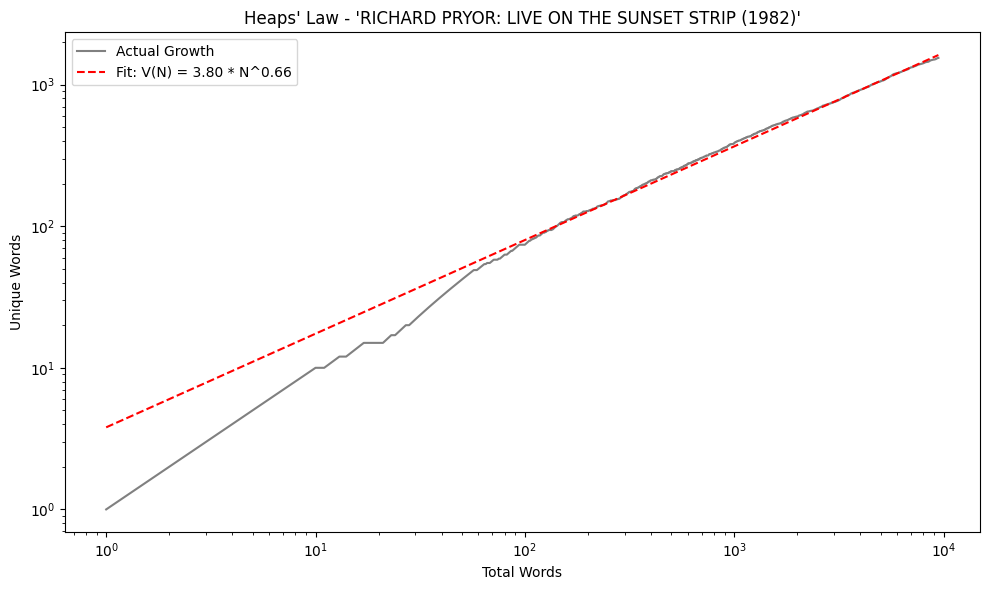

Slope (beta): 0.66
Intercept: 0.58
R-squared: 0.99
Total words: 7253
Unique words: 1484


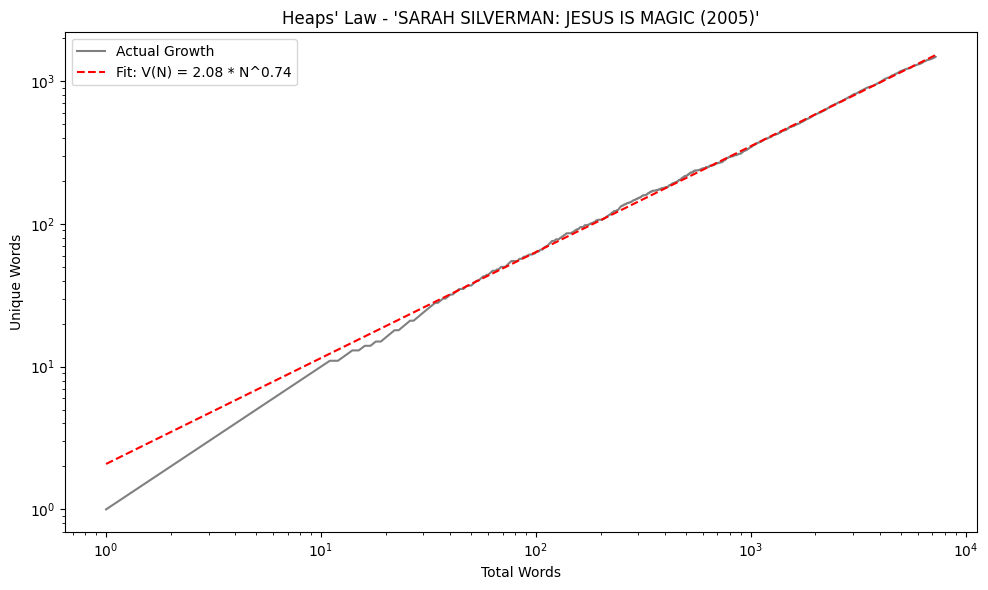

Slope (beta): 0.74
Intercept: 0.32
R-squared: 1.00
Total words: 4329
Unique words: 1116


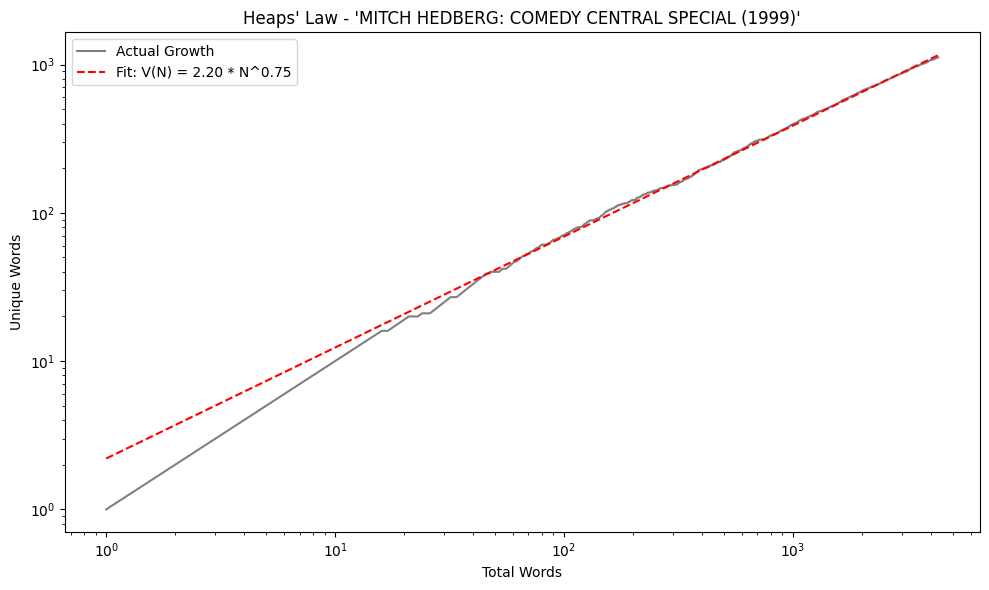

Slope (beta): 0.75
Intercept: 0.34
R-squared: 1.00
Total words: 13771
Unique words: 2971


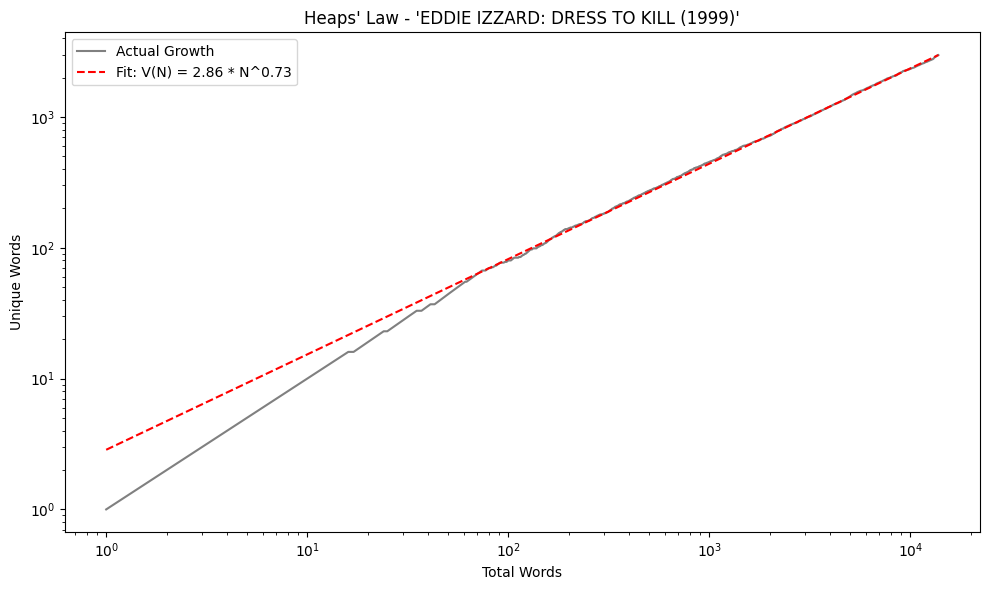

Slope (beta): 0.73
Intercept: 0.46
R-squared: 1.00


In [227]:
from scipy.stats import linregress

def plot_heaps_law(df, title):
    """Plots Heaps' Law based on vocabulary growth for a single comedy set and performs a linear fit."""
    transcript = df[df['title'] == title]['transcript'].values[0]
    words = tokenize_words(transcript, remove_stop_words=False)
    vocab_growth = calculate_vocabulary_growth(words)
    
    # Extract total words and unique words from the vocabulary growth
    total_words = vocab_growth[:, 0]
    unique_words = vocab_growth[:, 1]
    print(f"Total words: {total_words[-1]}")
    print(f"Unique words: {unique_words[-1]}")
    # Log-transform the data
    log_total_words = np.log10(total_words)
    log_unique_words = np.log10(unique_words)

    # Perform linear regression on the log-transformed data
    slope, intercept, r_value, p_value, std_err = linregress(log_total_words, log_unique_words)

    # Plotting the vocabulary growth (Heaps' Law)
    plt.figure(figsize=(10, 6))
    plt.plot(total_words, unique_words, color='grey', label='Actual Growth')
    
    # Plotting the fitted line
    fitted_line = 10**intercept * total_words**slope
    plt.plot(total_words, fitted_line, linestyle='--', color='red', label=f'Fit: V(N) = {10**intercept:.2f} * N^{slope:.2f}')

    # Labels and title
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Total Words")
    plt.ylabel("Unique Words")
    plt.title(f"Heaps' Law - '{title}'")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print the regression results
    print(f"Slope (beta): {slope:.2f}")
    print(f"Intercept: {intercept:.2f}")
    print(f"R-squared: {r_value**2:.2f}")

# Example usage:
plot_heaps_law(df, 'RICHARD PRYOR: LIVE ON THE SUNSET STRIP (1982)')
plot_heaps_law(df, 'SARAH SILVERMAN: JESUS IS MAGIC (2005)')
plot_heaps_law(df, 'MITCH HEDBERG: COMEDY CENTRAL SPECIAL (1999)')
plot_heaps_law(df, 'EDDIE IZZARD: DRESS TO KILL (1999)')


In [217]:
title = "SARAH SILVERMAN: JESUS IS MAGIC (2005)"
jesus_is_magic = df[df['title'] == title]['transcript'].values[0]

jesus_is_magic_words = tokenize_words(jesus_is_magic, remove_stop_words=False)

# Generate word data using the tokenized words
jesus_is_magic_word_data = get_word_data(jesus_is_magic_words)

def get_word_counts(df):
    count_once = 0
    count_twice = 0
    count_thrice = 0
    # Loop through the dataframe and increment the respective counter
    for count in df['counts']:
        if count == 1:
            count_once += 1
        elif count == 2:
            count_twice += 1
        elif count == 3:
            count_thrice += 1
    print("The total number of words is: ", df["counts"].sum(), " and the number of unique words is: ", len(df))
    print(f"Unique Words that appear once: {count_once}")
    print(f"Unique Words that appear twice: {count_twice}")
    print(f"Unique Words that appear three times: {count_thrice}")
    print("\n-------\n")
    print("Thus our n_1^g estimate is: ", round(count_once / len(df), 3))
    print("Thus our n_2^g estimate is: ", round(count_twice / len(df), 3))
    print("Thus our n_3^g estimate is: ", round(count_thrice / len(df), 3))
    print("\n-------------\n")
    # Innovation rate estimate
    rho_est = len(df) / df["counts"].sum()
    return rho_est

def calculate_theoretical_values(rho_est):
    n_1 = 1 / (2 - rho_est)
    n_2 = n_1 * (1 - rho_est) / (1 + (1 - rho_est) * 2)
    n_3 = n_2 * (2 - 2 * rho_est) / (1 + (1 - rho_est) * 3)   
    return n_1, n_2, n_3

rho = get_word_counts(jesus_is_magic_word_data)
print(f"Estimated rho: {rho}")
n_1, n_2, n_3 = calculate_theoretical_values(rho)

print(f"Theoretical n_1^g: {n_1}")
print(f"Theoretical n_2^g: {n_2}")
print(f"Theoretical n_3^g: {n_3}")

The total number of words is:  7253  and the number of unique words is:  1484
Unique Words that appear once: 839
Unique Words that appear twice: 226
Unique Words that appear three times: 107

-------

Thus our n_1^g estimate is:  0.565
Thus our n_2^g estimate is:  0.152
Thus our n_3^g estimate is:  0.072

-------------

Estimated rho: 0.2046049910381911
Theoretical n_1^g: 0.5569804945476885
Theoretical n_2^g: 0.17099784327846387
Theoretical n_3^g: 0.0803327815857865
